In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Import Data

Data sets are stored as netcf files, where each file is a one-dimensional time series of potential solar PV generation for each major city.

In [2]:
file_path = Path('/g/data/gb02/cd3022/hot-and-cloudy/solar-pv/GCCSA/')

files = list(file_path.glob(f"*.nc"))
ds = xr.open_mfdataset(files, combine='nested')

ERROR 1: PROJ: proj_create_from_database: Open of /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/share/proj failed


In [3]:
ds

<xarray.Dataset> Size: 20MB
Dimensions:  (time: 355599)
Coordinates:
  * time     (time) datetime64[ns] 3MB 2015-08-01T04:30:00 ... 2025-01-31T21:...
Data variables:
    1GSYD    (time) float64 3MB dask.array<chunksize=(355599,), meta=np.ndarray>
    2GMEL    (time) float64 3MB dask.array<chunksize=(355599,), meta=np.ndarray>
    3GBRI    (time) float64 3MB dask.array<chunksize=(355599,), meta=np.ndarray>
    4GADE    (time) float64 3MB dask.array<chunksize=(355599,), meta=np.ndarray>
    6GHOB    (time) float64 3MB dask.array<chunksize=(355599,), meta=np.ndarray>
    8ACTE    (time) float64 3MB dask.array<chunksize=(355599,), meta=np.ndarray>

### Remove the missing timestep from each day

Himawari skips a sample once a day for maintainence. The data looks better if this time step is removed.

In [4]:
ds = ds.where(ds['time'].dt.strftime('%H:%M') != '12:40', drop=True)

### Remove 3 bad days of Himawari data

Errors in the underlying irradiance dataset. Not during the hot months of interest, but code is here in case anyone wants to look at the other months

In [5]:
bad_days = [
    np.datetime64('2019-08-12'),
    np.datetime64('2019-10-01'),
    np.datetime64('2020-09-06'),
    
]
ds_dates = ds['time'].dt.floor('D')
good_time_mask = ~ds_dates.isin(bad_days)
ds = ds.sel(time=ds['time'][good_time_mask])

### Convert to Capacity Factors

In [6]:
# Rated capacity taken from sandia_modules['Canadian_Solar_CS5P_220M___2009_'], solar panel used in pvlib system,
# using the calculation rated_capacity = module.loc['Impo'] * module.loc['Vmpo']
rated_capacity = 219.656729124
ds = ds.apply(lambda x: x / rated_capacity) # raw data can be used for load duration curves, before morning/evening data is removed in "clip_dusk_dawn"

### Replace missing values with 0

So when a daily mean is taken, days of different lengths can be compared

In [38]:
ds = xr.where(ds.isnull(), 0, ds)

# Plotting

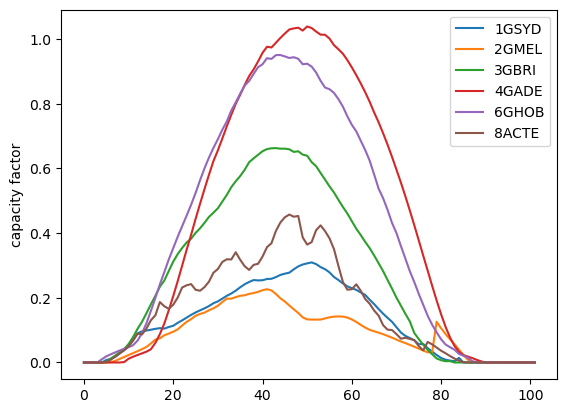

In [66]:
# Example day
date = '2020-01-06'
for reg in ds.data_vars:
    plt.plot(ds[reg].sel(time=date), label=reg)
    plt.legend()
    plt.ylabel('capacity factor')

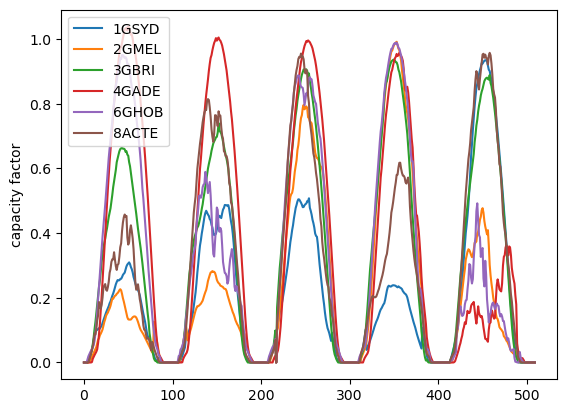

In [40]:
# Multiple days
start = '2020-01-06'
end = '2020-01-10'
for reg in ds.data_vars:
    plt.plot(ds[reg].sel(time=slice(start, end)), label=reg)
    plt.legend()
    plt.ylabel('capacity factor')

# Find Cloudy Days

Very simplified method for identifying cloudy days. The script simply converts the data into daily mean capacity factors, and then finds days that fall below a threshold of this.

In [64]:
# Resample to daily
daily = ds.resample(time='1D').mean()
daily = daily.compute()

# restrict data to the warm months (summer +/- 1)
warm_months = [1,2,3,11,12]
daily_warm_months = daily.where(daily.time.dt.month.isin(warm_months), drop=True)

threshold = 0.1

for reg in daily.data_vars:
    cloudy = daily_warm_months[reg].where(daily_warm_months[reg] < threshold, drop=True)
    print(f'Cloudy days for {reg}:')
    print(cloudy.time)

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_met

Cloudy days for 1GSYD:
<xarray.DataArray 'time' (time: 77)> Size: 616B
array(['2015-11-03T00:00:00.000000000', '2015-11-04T00:00:00.000000000',
       '2015-12-22T00:00:00.000000000', '2016-01-05T00:00:00.000000000',
       '2016-01-06T00:00:00.000000000', '2016-03-29T00:00:00.000000000',
       '2016-12-15T00:00:00.000000000', '2016-12-16T00:00:00.000000000',
       '2017-02-07T00:00:00.000000000', '2017-02-25T00:00:00.000000000',
       '2017-03-17T00:00:00.000000000', '2017-03-23T00:00:00.000000000',
       '2017-03-30T00:00:00.000000000', '2017-11-04T00:00:00.000000000',
       '2017-11-05T00:00:00.000000000', '2017-12-04T00:00:00.000000000',
       '2017-12-21T00:00:00.000000000', '2017-12-25T00:00:00.000000000',
       '2017-12-26T00:00:00.000000000', '2018-01-31T00:00:00.000000000',
       '2018-02-14T00:00:00.000000000', '2018-02-25T00:00:00.000000000',
       '2018-03-05T00:00:00.000000000', '2018-03-21T00:00:00.000000000',
       '2018-11-07T00:00:00.000000000', '2018-11-28T0